# Chapter 1: Getting started with pandas

In [ ]:
# To check panda instalationn status

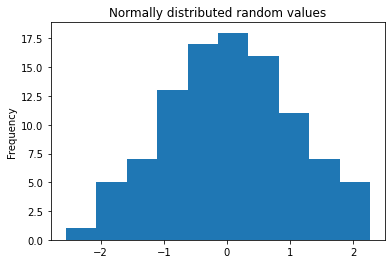

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

np.random.seed(0)
values = np.random.randn(100) # array of normaly distributed random numbers
s = pd.Series(values) # generate panda series
s.plot(kind='hist', title='Normally distributed random values') # hist computes distribution
plt.show()

In [4]:
# Check some of the data's statistics (mean, standard deviation, etc.)
s.describe()

count    100.000000
mean       0.059808
std        1.012960
min       -2.552990
25%       -0.643857
50%        0.094096
75%        0.737077
max        2.269755
dtype: float64

In [9]:
df = pd.DataFrame({'A':[1, 2, 1, 4, 3, 5, 2, 3, 4, 1],
                   'B':[12, 14, 11, 16, 18, 18, 22, 13, 21, 17],
                   'C':['a', 'a', 'b', 'a', 'b', 'c', 'b', 'a', 'b', 'a']
                  })

df

,A,B,C
0,1,12,a
1,2,14,a
2,1,11,b
3,4,16,a
4,3,18,b
5,5,18,c
6,2,22,b
7,3,13,a
8,4,21,b
9,1,17,a


In [10]:
df.describe ()

,A,B
count,10.000000,10.000000
mean,2.600000,16.200000
std,1.429841,3.705851
min,1.000000,11.000000
25%,1.250000,13.250000
50%,2.500000,16.500000
75%,3.750000,18.000000
max,5.000000,22.000000


**Note that since C is not a numerical column, it is excluded from the output.**

In [13]:
df['C'].describe()

count     10
unique     3
top        a
freq       5
Name: C, dtype: object

**In this case the method summarizes categorical data by number of observations, number of
unique elements, mode, and frequency of the mode.**

# Chapter 3: Appending to DataFrame

In [17]:
# Appending a new row to DataFrame
df = pd.DataFrame(['A','B','C'])
df

,0
0,A
1,B
2,C


In [18]:
df = pd.DataFrame(columns = ['A','B','C'])
df

,A,B,C


In [20]:
# Appending a row by a single column value:
df.loc[0,'A'] = 1 # index, column name, value to set
df

,A,B,C
0,1,NaN,NaN


In [26]:
# Appending a row, given list of values:
df.loc[1] = [2,3,4]
df

,A,B,C
0,1,NaN,NaN
1,2,3,4


In [28]:
# Appending a row given a dictionary
df.loc[2] = {'A':3,'B':5,'C':7}
df

,A,B,C
0,1,NaN,NaN
1,2,3,4
2,3,5,7


In [32]:
# The first input in .loc[] is the index. If you use an existing index, you will overwrite the values in that row:
df.loc[0] = ['',7,8]
df

,A,B,C
0,,7,8
1,2,3,4
2,3,5,7


In [33]:
df.loc[0,'A'] = 1
df

,A,B,C
0,1,7,8
1,2,3,4
2,3,5,7


In [34]:
# Append a DataFrame to another DataFrame
df1 = pd.DataFrame(columns = ['A','B'])
df1.loc[0] = ['a1','b1']
df1.loc[1] = ['a2','b2']
df1

,A,B
0,a1,b1
1,a2,b2


In [651]:
df2 = pd.DataFrame(columns = ['B','C'])
df2.loc[0] = ['b1','c1']
df2

,B,C
0,b1,c1


**The two DataFrames are not required to have the same set of columns. The append method does
not change either of the original DataFrames. Instead, it returns a new DataFrame by appending
the original two. Appending a DataFrame to another one is quite simple:**

In [37]:
df1.append(df2)

,A,B,C
0,a1,b1,NaN
1,a2,b2,NaN
0,NaN,b1,c1


**As you can see, it is possible to have duplicate indices (0 in this example). To avoid this issue, you
may ask Pandas to reindex the new DataFrame for you:**

In [38]:
df1.append(df2, ignore_index = True)

,A,B,C
0,a1,b1,NaN
1,a2,b2,NaN
2,NaN,b1,c1


# Chapter 4: Boolean indexing of dataframes

**Accessing rows in a dataframe using the DataFrame indexer objects .ix, .loc, .iloc and how it
differentiates itself from using a boolean mask.**

In [41]:
df = pd.DataFrame({"color": ['red', 'blue', 'red', 'blue']},
 index=[True, False, True, False])
 
df

,color
True,red
False,blue
True,red
False,blue


In [42]:
# Accessing with .loc
df.loc[True]

,color
True,red
True,red


In [ ]:
# Accessing with .iloc
df.iloc[True] # TypeError: Cannot index by location index with a non-integer key

# Important to note is that older pandas versions did not distinguish between boolean
# and integer input, thus .iloc[True] would return the same as .iloc[1]

In [45]:
df.iloc[1]

color    blue
dtype: object

In [ ]:
# Accessing with .ix
df.ix[1] # AttributeError: 'DataFrame' object has no attribute 'ix'

**Applying a boolean mask to a dataframe**

In [ ]:
color name size
0 red rose big
1 blue violet big
2 red tulip small
3 blue harebell small

In [50]:
df = pd.DataFrame({'Color':['red','blue','red','blue'],
                   'Name':['rose','violet','tulip','harebell'],
                   'Size':['big','big','small','small']})

df

,Color,Name,Size
0,red,rose,big
1,blue,violet,big
2,red,tulip,small
3,blue,harebell,small


**Using the magic __getitem__ or [] accessor. Giving it a list of True and False of the same length as
the dataframe will give you:**

In [55]:
df[[True, False, True, False]] # without [] would raise error

,Color,Name,Size
0,red,rose,big
2,red,tulip,small


In [61]:
df[[False, True, True, False]] # without [] would raise error

,Color,Name,Size
1,blue,violet,big
2,red,tulip,small


**Masking data based on column value**

In [64]:
df['Size'] == 'small' 
# Accessing a single column from a data frame, we can use a simple comparison == to compare
# every element in the column to the given variable, producing a pd.Series of True and False

0    False
1    False
2     True
3     True
Name: Size, dtype: bool

**This pd.Series is an extension of an np.array which is an extension of a simple list, Thus we can
hand this to the __getitem__ or [] accessor as in the above example.**

In [65]:
size_small_mask = df['Size'] == 'small'
type(size_small_mask)

pandas.core.series.Series

In [68]:
df[size_small_mask]

,Color,Name,Size
2,red,tulip,small
3,blue,harebell,small


**Masking data based on index value**

We can create a mask based on the index values, just like on a column value.

In [71]:
rose_mask = df.index == 'rose'
df[rose_mask]

/opt/anaconda3/lib/python3.8/site-packages/pandas/core/indexes/base.py:122: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  result = op(self.values, np.asarray(other))


,Color,Name,Size


In [ ]:
# Same as
df.loc['rose'] # KeyError: 'rose'

The important difference being, when .loc only encounters one row in the index that matches, it
will return a pd.Series, if it encounters more rows that matches, it will return a pd.DataFrame. This
makes this method rather unstable.
This behavior can be controlled by giving the .loc a list of a single entry. This will force it to return
a data frame.


In [ ]:
df.loc[['rose']]

# Chapter 5: Categorical data

**Categoricals are a pandas data type, which correspond to categorical variables in statistics: a
variable, which can take on only a limited, and usually fixed, number of possible values
(categories; levels in R). Examples are gender, social class, blood types, country affiliations,
observation time or ratings via Likert scales. Source: Pandas Docs**

In [76]:
# Object Creation
s = pd.Series(['a','b','c','a','b'], dtype = "category")
s

0    a
1    b
2    c
3    a
4    b
dtype: category
Categories (3, object): [a, b, c]

In [79]:
df = pd.DataFrame({"A":["a","b","c","a","c"]})
df["B"] = df["A"].astype('category')
df["C"] = pd.Categorical(df["A"])
df

,A,B,C
0,a,a,a
1,b,b,b
2,c,c,c
3,a,a,a
4,c,c,c


In [82]:
df.dtypes

A      object
B    category
C    category
dtype: object

**Creating large random datasets**

In [84]:
df = pd.DataFrame(np.random.choice(['foo','bar','baz'], size = (100000,3)))
df = df.apply(lambda col:col.astype('category'))

df.head()


,0,1,2
0,bar,foo,foo
1,foo,bar,foo
2,bar,baz,bar
3,foo,foo,bar
4,bar,foo,baz


In [85]:
df.dtypes

0    category
1    category
2    category
dtype: object

In [86]:
df.shape

(100000, 3)

# Chapter 6: Computational Tools

Find The Correlation Between Columns. Suppose you have a DataFrame of numerical values, for example:


In [88]:
df = pd.DataFrame(np.random.randn(1000,3), columns=['a','b','c'])

In [89]:
df.corr()

,a,b,c
a,1.000000,0.011249,-0.023090
b,0.011249,1.000000,0.016686
c,-0.023090,0.016686,1.000000


**will find the Pearson correlation between the columns. Note how the diagonal is 1, as each column
is (obviously) fully correlated with itself.
pd.DataFrame.correlation takes an optional method parameter, specifying which algorithm to use.
The default is pearson. To use Spearman correlation, for example, use**

In [95]:
df.corr(method = 'spearman')

,a,b,c
a,1.000000,0.013051,-0.016772
b,0.013051,1.000000,0.010594
c,-0.016772,0.010594,1.000000


# Chapter 7: Creating DataFrames

DataFrame is a data structure provided by pandas library,apart from Series & Panel. It is a 2-
dimensional structure & can be compared to a table of rows and columns.

Each row can be identified by an integer index (0..N) or a label explicitly set when creating a
DataFrame object. Each column can be of distinct type and is identified by a label.

This topic covers various ways to construct/create a DataFrame object. Ex. from Numpy arrays,
from list of tuples, from dictionary.

In [ ]:
# Create a sample DataFrame
import pandas as pd


**Create a DataFrame from a dictionary, containing two columns: numbers and colors. Each key
represent a column name and the value is a series of data, the content of the column:**

In [100]:
df = pd.DataFrame({"Numbers" : [1,2,3],"Colors":["red","white","blue"]}, columns = ['Numbers','Colors'])
df

,Numbers,Colors
0,1,red
1,2,white
2,3,blue


In [101]:
print(df)

   Numbers Colors
0        1    red
1        2  white
2        3   blue


**Create a sample DataFrame using Numpy**

In [106]:
import numpy as np
import pandas as pd

# set the seed for a reproducible sample
np.random.seed(0)

df = pd.DataFrame(np.random.randn(5,3), columns = list('ABC'))
print(df)

          A         B         C
0  1.764052  0.400157  0.978738
1  2.240893  1.867558 -0.977278
2  0.950088 -0.151357 -0.103219
3  0.410599  0.144044  1.454274
4  0.761038  0.121675  0.443863


**Create a DataFrame with integers:**

In [108]:
df = pd.DataFrame(np.arange(15).reshape(5,3), columns=list('ABC'))
print(df)

    A   B   C
0   0   1   2
1   3   4   5
2   6   7   8
3   9  10  11
4  12  13  14


**Create a DataFrame and include nans (NaT, NaN, 'nan', None) across columns and rows:**

In [111]:
df = pd.DataFrame(np.arange(48).reshape(8,6), columns = list('ABCDEF'))
print(df)

    A   B   C   D   E   F
0   0   1   2   3   4   5
1   6   7   8   9  10  11
2  12  13  14  15  16  17
3  18  19  20  21  22  23
4  24  25  26  27  28  29
5  30  31  32  33  34  35
6  36  37  38  39  40  41
7  42  43  44  45  46  47


In [116]:
# in column 0, set elements with indices 0,2,4, ... to NaN
df.iloc[::2,0] = np.nan 
df

,A,B,C,D,E,F
0,NaN,1,2,3,4,5
1,6.0,7,8,9,10,11
2,NaN,13,14,15,16,17
3,18.0,19,20,21,22,23
4,NaN,25,26,27,28,29
5,30.0,31,32,33,34,35
6,NaN,37,38,39,40,41
7,42.0,43,44,45,46,47


In [120]:
 # in column 1, set elements with indices 0,4, ... to np.NaT
df.iloc[::4,1] = pd.NaT
df

,A,B,C,D,E,F
0,NaN,NaT,2,3,4,5
1,6.0,7,8,9,10,11
2,NaN,13,14,15,16,17
3,18.0,19,20,21,22,23
4,NaN,NaT,26,27,28,29
5,30.0,31,32,33,34,35
6,NaN,37,38,39,40,41
7,42.0,43,44,45,46,47


In [121]:
# in column 2, set elements with index from 0 to 3 to 'nan'
df.iloc[0:3,2] = np.nan
df

,A,B,C,D,E,F
0,NaN,NaT,NaN,3,4,5
1,6.0,7,NaN,9,10,11
2,NaN,13,NaN,15,16,17
3,18.0,19,20.0,21,22,23
4,NaN,NaT,26.0,27,28,29
5,30.0,31,32.0,33,34,35
6,NaN,37,38.0,39,40,41
7,42.0,43,44.0,45,46,47


In [123]:
# in column 5, set all elements to None
df.iloc[:,5] = None
df

,A,B,C,D,E,F
0,NaN,NaT,NaN,3,4,None
1,6.0,7,NaN,9,10,None
2,NaN,13,NaN,15,16,None
3,18.0,19,20.0,21,22,None
4,NaN,NaT,26.0,27,28,None
5,30.0,31,32.0,33,34,None
6,NaN,37,38.0,39,40,None
7,42.0,43,44.0,45,46,None


In [124]:
# in row 5, set all elements to None
df.iloc[5,:] = None
df

,A,B,C,D,E,F
0,NaN,NaT,NaN,3.0,4.0,None
1,6.0,7,NaN,9.0,10.0,None
2,NaN,13,NaN,15.0,16.0,None
3,18.0,19,20.0,21.0,22.0,None
4,NaN,NaT,26.0,27.0,28.0,None
5,NaN,None,NaN,NaN,NaN,None
6,NaN,37,38.0,39.0,40.0,None
7,42.0,43,44.0,45.0,46.0,None


In [126]:
# in row 7, set all elements to NaN
df.iloc[7,:] = np.nan
df

,A,B,C,D,E,F
0,NaN,NaT,NaN,3.0,4.0,None
1,6.0,7,NaN,9.0,10.0,None
2,NaN,13,NaN,15.0,16.0,None
3,18.0,19,20.0,21.0,22.0,None
4,NaN,NaT,26.0,27.0,28.0,None
5,NaN,None,NaN,NaN,NaN,None
6,NaN,37,38.0,39.0,40.0,None
7,NaN,NaN,NaN,NaN,NaN,NaN


**Create a sample DataFrame from multiple collections using Dictionary**

In [129]:
import pandas as pd
import numpy as np

np.random.seed(123)
x = np.random.standard_normal(4)
y = range(4)

df = pd.DataFrame({"X":x, "Y":y})
df

,X,Y
0,-1.085631,0
1,0.997345,1
2,0.282978,2
3,-1.506295,3


**Create a DataFrame from a list of tuples.
You can create a DataFrame from a list of simple tuples, and can even choose the specific
elements of the tuples you want to use. Here we will create a DataFrame using all of the data in
each tuple except for the last element.**

In [133]:
data = [('p1', 't1', 1, 2),
        ('p1', 't2', 3, 4),
        ('p2', 't1', 5, 6),
        ('p2', 't2', 7, 8),
        ('p2', 't3', 2, 8)]

type(data)

list

In [134]:
df = pd.DataFrame(data)
df

,0,1,2,3
0,p1,t1,1,2
1,p1,t2,3,4
2,p2,t1,5,6
3,p2,t2,7,8
4,p2,t3,2,8


**Create a DataFrame from a dictionary of lists.
Create a DataFrame from multiple lists by passing a dict whose values lists. The keys of the
dictionary are used as column labels. The lists can also be ndarrays. The lists/ndarrays must all be the same length.**


In [136]:
# Create DF from dict of lists/ndarrays
df = pd.DataFrame({'A' : [1, 2, 3, 4],
                   'B' : [4, 3, 2, 1]
                  })
df

,A,B
0,1,4
1,2,3
2,3,2
3,4,1


In [ ]:
#If the arrays are not the same length an error is raised
df = pd.DataFrame({'A' : [1, 2, 3, 4], 'B' : [5, 5, 5]}) # a ValueError is raised

**Using ndarrays**

In [137]:
import pandas as pd
import numpy as np

np.random.seed(123)
x = np.random.standard_normal(4)
y = range(4)
df = pd.DataFrame({'X':x, 'Y':y})
df

,X,Y
0,-1.085631,0
1,0.997345,1
2,0.282978,2
3,-1.506295,3


**Create a sample DataFrame with datetime**

In [148]:
import pandas as pd
import numpy as np

np.random.seed(0)
# create an array of 5 dates starting at '2015-02-24', one per minute
rng  = pd.date_range('2015-02-24', periods=5, freq='T')
df = pd.DataFrame({'Date':rng,'Val': np.random.randn(len(rng))})
df

,Date,Val
0,2015-02-24 00:00:00,1.764052
1,2015-02-24 00:01:00,0.400157
2,2015-02-24 00:02:00,0.978738
3,2015-02-24 00:03:00,2.240893
4,2015-02-24 00:04:00,1.867558


In [149]:
# create an array of 5 dates starting at '2015-02-24', one per day
# create an array of 5 dates starting at '2015-02-24', one per day
rng = pd.date_range('2015-02-24', periods=5, freq='D')
df = pd.DataFrame({ 'Date': rng, 'Val' : np.random.randn(len(rng))})
print (df)

        Date       Val
0 2015-02-24 -0.977278
1 2015-02-25  0.950088
2 2015-02-26 -0.151357
3 2015-02-27 -0.103219
4 2015-02-28  0.410599


In [153]:
# create an array of 5 dates starting at '2015-02-24', one every 3 years
rng = pd.date_range('2015-04-24',periods=5, freq='3A')
df = pd.DataFrame({"Date": rng,  "Val":np.random.randn(len(rng))})
print(df)

        Date       Val
0 2015-12-31 -2.552990
1 2018-12-31  0.653619
2 2021-12-31  0.864436
3 2024-12-31 -0.742165
4 2027-12-31  2.269755


**DataFrame with DatetimeIndex:**

In [155]:
import pandas as pd
import numpy as np

np.random.seed(0)
rng = pd.date_range('2015-02-24', periods=5, freq='T')
df = pd.DataFrame({ 'Val' : np.random.randn(len(rng)) }, index=rng)
print (df)

                          Val
2015-02-24 00:00:00  1.764052
2015-02-24 00:01:00  0.400157
2015-02-24 00:02:00  0.978738
2015-02-24 00:03:00  2.240893
2015-02-24 00:04:00  1.867558


**Offset-aliases for parameter freq in date_range:**

    Alias Description

- B business day frequency
- C custom business day frequency (experimental)
- D calendar day frequency
- W weekly frequency
- M month end frequency
- BM business month end frequency
- CBM custom business month end frequency
- MS month start frequency
- BMS business month start frequency
- CBMS custom business month start frequency
- Q quarter end frequency
- BQ business quarter endfrequency
- QS quarter start frequency
- BQS business quarter start frequency
- A year end frequency
- BA business year end frequency
- AS year start frequency
- BAS business year start frequency
- BH business hour frequency
- H hourly frequency
- T, min minutely frequency
- S secondly frequency
- L, ms milliseconds
- U, us microseconds
- N nanoseconds

**Create a sample DataFrame with MultiIndex**

In [158]:
# Using from_tuples:
np.random.seed(0)

tuples = list(zip(*[
                    ['bar', 'bar', 'baz', 'baz','foo', 'foo', 'qux', 'qux'],
                    ['one', 'two', 'one', 'two','one', 'two', 'one', 'two']
                   ]
                 )
             )

idx = pd.MultiIndex.from_tuples(tuples, names=['first', 'second'])

idx

MultiIndex([('bar', 'one'),
            ('bar', 'two'),
            ('baz', 'one'),
            ('baz', 'two'),
            ('foo', 'one'),
            ('foo', 'two'),
            ('qux', 'one'),
            ('qux', 'two')],
           names=['first', 'second'])

In [159]:
# Using from_product:

idx = pd.MultiIndex.from_product([['bar', 'baz', 'foo', 'qux'],['one','two']])
idx

MultiIndex([('bar', 'one'),
            ('bar', 'two'),
            ('baz', 'one'),
            ('baz', 'two'),
            ('foo', 'one'),
            ('foo', 'two'),
            ('qux', 'one'),
            ('qux', 'two')],
           )

In [160]:
# Then, use this MultiIndex:
df = pd.DataFrame(np.random.randn(8, 2), index=idx, columns=['A', 'B'])
print (df)

                A         B
bar one  1.764052  0.400157
    two  0.978738  2.240893
baz one  1.867558 -0.977278
    two  0.950088 -0.151357
foo one -0.103219  0.410599
    two  0.144044  1.454274
qux one  0.761038  0.121675
    two  0.443863  0.333674


**Save and Load a DataFrame in pickle (.plk) format**

In [ ]:
import pandas as pd
# Save dataframe to pickled pandas object
df.to_pickle(file_name) # where to save it usually as a .plk
# Load dataframe from pickled pandas object
df= pd.read_pickle(file_name)

**Create a DataFrame from a list of dictionaries**

A DataFrame can be created from a list of dictionaries. Keys are used as column names

In [167]:
import pandas as pd

L = [{'Name': 'John', 'Last Name': 'Smith'},
     {'Name': 'Mary', 'Last Name': 'Wood'}]
pd.DataFrame(L)

,Name,Last Name
0,John,Smith
1,Mary,Wood


**Missing values are filled with NaNs**

In [170]:
L = [{'Name': 'John', 'Last Name': 'Smith', 'Age': 37},
     {'Name': 'Mary', 'Last Name': 'Wood'}]
pd.DataFrame(L)

,Name,Last Name,Age
0,John,Smith,37.0
1,Mary,Wood,NaN


# Chapter 8: Cross sections of different axes with MultiIndex

**Selection of cross-sections using .xs**

In [175]:
import pandas as pd
import numpy as np

arrays = [['bar', 'bar', 'baz', 'baz', 'foo', 'foo', 'qux', 'qux'],
          ['one', 'two', 'one', 'two', 'one', 'two', 'one', 'two']]

idx_row = pd.MultiIndex.from_arrays(arrays, names=['Row_First','Row_Second'])
idx_col = pd.MultiIndex.from_product([['A','B'],['i','ii']], names=['Col_First','Col_Second'])

df = pd.DataFrame(np.random.randn(8,4), index = idx_row, columns=idx_col)
df


Col_First                    A                   B          
Col_Second                   i        ii         i        ii
Row_First Row_Second                                        
bar       one         1.494079 -0.205158  0.313068 -0.854096
          two        -2.552990  0.653619  0.864436 -0.742165
baz       one         2.269755 -1.454366  0.045759 -0.187184
          two         1.532779  1.469359  0.154947  0.378163
foo       one        -0.887786 -1.980796 -0.347912  0.156349
          two         1.230291  1.202380 -0.387327 -0.302303
qux       one        -1.048553 -1.420018 -1.706270  1.950775
          two        -0.509652 -0.438074 -1.252795  0.777490

**.xs accepts a level (either the name of said level or an integer), and an axis: 0 for rows, 1 for
columns.
.xs is available for both pandas.Series and pandas.DataFrame.**

In [177]:
# Selection on rows:
df.xs('two', level='Row_Second', axis=0)

Col_First          A                   B          
Col_Second         i        ii         i        ii
Row_First                                         
bar        -2.552990  0.653619  0.864436 -0.742165
baz         1.532779  1.469359  0.154947  0.378163
foo         1.230291  1.202380 -0.387327 -0.302303
qux        -0.509652 -0.438074 -1.252795  0.777490

In [183]:
# Selection on columns:
df.xs('ii', level=1, axis=1)

Col_First                    A         B
Row_First Row_Second                    
bar       one        -0.205158 -0.854096
          two         0.653619 -0.742165
baz       one        -1.454366 -0.187184
          two         1.469359  0.378163
foo       one        -1.980796  0.156349
          two         1.202380 -0.302303
qux       one        -1.420018  1.950775
          two        -0.438074  0.777490

**.xs only works for selection , assignment is NOT possible (getting, not setting):¨**

In [ ]:
 df.xs('ii', level='Col_Second', axis=1) = 0 # SyntaxError: can't assign to function call

**Using .loc and slicers**

Unlike the .xs method, this allows you to assign values. Indexing using slicers is available since
version 0.14.0.

In [186]:
import pandas as pd
import numpy as np
arrays = [['bar', 'bar', 'baz', 'baz', 'foo', 'foo', 'qux', 'qux'],
 ['one', 'two', 'one', 'two', 'one', 'two', 'one', 'two']]
idx_row = pd.MultiIndex.from_arrays(arrays, names=['Row_First', 'Row_Second'])
idx_col = pd.MultiIndex.from_product([['A','B'], ['i', 'ii']],
names=['Col_First','Col_Second'])
df = pd.DataFrame(np.random.randn(8,4), index=idx_row, columns=idx_col)

df

Col_First                    A                   B          
Col_Second                   i        ii         i        ii
Row_First Row_Second                                        
bar       one        -1.165150  0.900826  0.465662 -1.536244
          two         1.488252  1.895889  1.178780 -0.179925
baz       one        -1.070753  1.054452 -0.403177  1.222445
          two         0.208275  0.976639  0.356366  0.706573
foo       one         0.010500  1.785870  0.126912  0.401989
          two         1.883151 -1.347759 -1.270485  0.969397
qux       one        -1.173123  1.943621 -0.413619 -0.747455
          two         1.922942  1.480515  1.867559  0.906045

In [187]:
# Selection on rows:
df.loc[(slice(None),'two'),:]

Col_First                    A                   B          
Col_Second                   i        ii         i        ii
Row_First Row_Second                                        
bar       two         1.488252  1.895889  1.178780 -0.179925
baz       two         0.208275  0.976639  0.356366  0.706573
foo       two         1.883151 -1.347759 -1.270485  0.969397
qux       two         1.922942  1.480515  1.867559  0.906045

In [188]:
# Selection on columns:
df.loc[:,(slice(None),'ii')]

Col_First                    A         B
Col_Second                  ii        ii
Row_First Row_Second                    
bar       one         0.900826 -1.536244
          two         1.895889 -0.179925
baz       one         1.054452  1.222445
          two         0.976639  0.706573
foo       one         1.785870  0.401989
          two        -1.347759  0.969397
qux       one         1.943621 -0.747455
          two         1.480515  0.906045

In [189]:
# Selection on both axis::
df.loc[(slice(None),'two'),(slice(None),'ii')]

,Col_First,A,B
,Col_Second,ii,ii
Row_First,Row_Second,,
bar,two,1.895889,-0.179925
baz,two,0.976639,0.706573
foo,two,-1.347759,0.969397
qux,two,1.480515,0.906045


In [191]:
# Assignment works (unlike .xs):
df.loc[(slice(None),'two'),(slice(None),'ii')]=0
df

Col_First                    A                   B          
Col_Second                   i        ii         i        ii
Row_First Row_Second                                        
bar       one        -1.165150  0.900826  0.465662 -1.536244
          two         1.488252  0.000000  1.178780  0.000000
baz       one        -1.070753  1.054452 -0.403177  1.222445
          two         0.208275  0.000000  0.356366  0.000000
foo       one         0.010500  1.785870  0.126912  0.401989
          two         1.883151  0.000000 -1.270485  0.000000
qux       one        -1.173123  1.943621 -0.413619 -0.747455
          two         1.922942  0.000000  1.867559  0.000000

# Chapter 9: Data Types

dtypes are not native to pandas. They are a result of pandas close architectural coupling to
numpy.

the dtype of a column does not in any way have to correlate to the python type of the object
contained in the column.

Here we have a pd.Series with floats. The dtype will be float.
Then we use astype to "cast" it to object

In [193]:
pd.Series([1.,2.,3.,4.,5.]).astype(object)

0    1
1    2
2    3
3    4
4    5
dtype: object

The dtype is now object, but the objects in the list are still float. Logical if you know that in python,
everything is an object, and can be upcasted to object.

In [195]:
type(pd.Series([1.,2.,3.,4.,5.]).astype(object)[0])

float

In [196]:
# Here we try "casting" the floats to strings.
pd.Series([1.,2.,3.,4.,5.]).astype(str)

0    1.0
1    2.0
2    3.0
3    4.0
4    5.0
dtype: object

The dtype is now object, but the type of the entries in the list are string. This is because numpy does
not deal with strings, and thus acts as if they are just objects and of no concern.

In [197]:
type(pd.Series([1.,2.,3.,4.,5.]).astype(str)[0])

str

Do not trust dtypes, they are an artifact of an architectural flaw in pandas. Specify them as you
must, but do not rely on what dtype is set on a column.

Checking the types of columns
Types of columns can be checked by .dtypes atrribute of DataFrames.

In [199]:
df = pd.DataFrame({'A': [1, 2, 3], 'B': [1.0, 2.0, 3.0], 'C': [True, False, True]})
df

,A,B,C
0,1,1.0,True
1,2,2.0,False
2,3,3.0,True


In [200]:
df.dtypes

A      int64
B    float64
C       bool
dtype: object

In [201]:
# For a single series, you can use .dtype attribute.
df['A'].dtypes

dtype('int64')

Changing dtypes

astype() method changes the dtype of a Series and returns a new Series.

In [202]:
df = pd.DataFrame({'A': [1, 2, 3], 'B': [1.0, 2.0, 3.0],
                   'C': ['1.1.2010', '2.1.2011', '3.1.2011'],
                   'D': ['1 days', '2 days', '3 days'],
                   'E': ['1', '2', '3']})

df


,A,B,C,D,E
0,1,1.0,1.1.2010,1 days,1
1,2,2.0,2.1.2011,2 days,2
2,3,3.0,3.1.2011,3 days,3


In [203]:
df.dtypes

A      int64
B    float64
C     object
D     object
E     object
dtype: object

In [204]:
# Change the type of column A to float
df['A'].astype('float')

0    1.0
1    2.0
2    3.0
Name: A, dtype: float64

In [206]:
# and type of column B to integer:
df['B'].astype('int')

0    1
1    2
2    3
Name: B, dtype: int64

**astype() method is for specific type conversion (i.e. you can specify .astype(float64'),
.astype(float32), or .astype(float16)). For general conversion, you can use pd.to_numeric,
pd.to_datetime and pd.to_timedelta.**

Changing the type to numeric

pd.to_numeric changes the values to a numeric type

In [207]:
pd.to_numeric(df['E'])

0    1
1    2
2    3
Name: E, dtype: int64

In [208]:
# By default, pd.to_numeric raises an error if an input cannot be converted to a number. 
# You can change that behavior by using the errors parameter.

pd.to_numeric(pd.Series(['1', '2', 'a']), errors='ignore')

0    1
1    2
2    a
dtype: object

In [209]:
# Return NaN when the input cannot be converted to a number
pd.to_numeric(pd.Series(['1', '2', 'a']), errors='coerce')

0    1.0
1    2.0
2    NaN
dtype: float64

In [212]:
# If need check all rows with input cannot be converted to numeric use boolean indexing with isnull:
df = pd.DataFrame({'A': [1, 'x', 'z'],
                   'B': [1.0, 2.0, 3.0],
                   'C': [True, False, True]})

pd.to_numeric(df.A, errors='coerce').isnull()

0    False
1     True
2     True
Name: A, dtype: bool

In [213]:
df[pd.to_numeric(df.A, errors='coerce').isnull()]

,A,B,C
1,x,2.0,False
2,z,3.0,True


**Changing the type to datetime**

In [217]:
pd.to_datetime(df['B'])

0   1970-01-01 00:00:00.000000001
1   1970-01-01 00:00:00.000000002
2   1970-01-01 00:00:00.000000003
Name: B, dtype: datetime64[ns]

In [216]:
#Note that 2.1.2011 is converted to February 1, 2011. If you want January 2, 2011 instead, you need to use the dayfirst parameter.
pd.to_datetime('2.1.2011', dayfirst=True)

Timestamp('2011-01-02 00:00:00')

**Changing the type to timedelta**

In [222]:
pd.to_timedelta(df['B'])

0   00:00:00.000000
1   00:00:00.000000
2   00:00:00.000000
Name: B, dtype: timedelta64[ns]

Selecting columns based on dtype

select_dtypes method can be used to select columns based on dtype.

In [223]:
df = pd.DataFrame({'A': [1, 2, 3], 'B': [1.0, 2.0, 3.0], 'C': ['a', 'b', 'c'],
 'D': [True, False, True]})

df

,A,B,C,D
0,1,1.0,a,True
1,2,2.0,b,False
2,3,3.0,c,True


In [224]:
#With include and exclude parameters you can specify which types you want:
# Select numbers
df.select_dtypes(include=['number']) # You need to use a list

,A,B
0,1,1.0
1,2,2.0
2,3,3.0


In [225]:
# Select numbers and booleans
df.select_dtypes(include=['number', 'bool'])

,A,B,D
0,1,1.0,True
1,2,2.0,False
2,3,3.0,True


In [226]:
# Select numbers and booleans but exclude int64
df.select_dtypes(include=['number', 'bool'], exclude=['int64'])

,B,D
0,1.0,True
1,2.0,False
2,3.0,True


In [229]:
# Summarizing dtypes
#get_dtype_counts method can be used to see a breakdown of dtypes.

df = pd.DataFrame({'A': [1, 2, 3], 'B': [1.0, 2.0, 3.0], 'C': ['a', 'b', 'c'],'D': [True, False, True]})

df.get_dtype_counts()

AttributeError: 'DataFrame' object has no attribute 'get_dtype_counts'

# Chapter 10: Dealing with categorical variables

In [231]:
# One-hot encoding with `get_dummies()`
df = pd.DataFrame({'Name':['John Smith','Mary Brown'],'Gender':['Male','Female'],'Smoker':['Y','N']})
print(df)

         Name  Gender Smoker
0  John Smith    Male      Y
1  Mary Brown  Female      N


In [232]:
df_with_dummies = pd.get_dummies(df,columns=['Gender','Smoker'])
print(df_with_dummies)

         Name  Gender_Female  Gender_Male  Smoker_N  Smoker_Y
0  John Smith              0            1         0         1
1  Mary Brown              1            0         1         0


# Chapter 11: Duplicated data

Select duplicated
If need set value 0 to column B, where in column A are duplicated data first create mask by
Series.duplicated and then use DataFrame.ix or Series.mask:

In [235]:
df = pd.DataFrame({'A':[1,2,3,3,2],'B':[1,7,3,0,8]})
mask = df.A.duplicated(keep=False)
mask

0    False
1     True
2     True
3     True
4     True
Name: A, dtype: bool

In [238]:
df.loc[mask, 'B'] = 0

In [240]:
df['C'] = df.A.mask(mask, 0)
df

,A,B,C
0,1,1,1
1,2,0,0
2,3,0,0
3,3,0,0
4,2,0,0


In [241]:
# If need invert mask use ~:
df['C'] = df.A.mask(~mask, 0)
df

,A,B,C
0,1,1,0
1,2,0,2
2,3,0,3
3,3,0,3
4,2,0,2


In [252]:
# Drop duplicated Use drop_duplicates:
df = pd.DataFrame({'A':[1,2,3,3,2],'B':[1,7,3,0,8]})

In [253]:
# keep only the last value
df.drop_duplicates(subset=['A'], keep='last')

,A,B
0,1,1
3,3,0
4,2,8


In [255]:
# # keep only the first value, default value
df.drop_duplicates(subset=['A'], keep='first')

,A,B
0,1,1
1,2,7
2,3,3


In [260]:
# drop all duplicated values
df.drop_duplicates(subset=['A'], keep=False)

,A,B
0,1,1


In [261]:
# When you don't want to get a copy of a data frame, but to modify the existing one:
df = pd.DataFrame({'A':[1,2,3,3,2],'B':[1,7,3,0,8]})
df.drop_duplicates(subset=['A'], inplace=True)
df

,A,B
0,1,1
1,2,7
2,3,3


**Counting and getting unique elements**

Number of unique elements in a series:

In [263]:
id_numbers = pd.Series([111, 112, 112, 114, 115, 118, 114, 118, 112])
id_numbers.nunique()

5

In [266]:
id_numbers.unique()

array([111, 112, 114, 115, 118])

In [269]:
df = pd.DataFrame({'Group': list('ABAABABAAB'),
                   'ID': [1, 1, 2, 3, 3, 2, 1, 2, 1, 3]})

df

,Group,ID
0,A,1
1,B,1
2,A,2
3,A,3
4,B,3
5,A,2
6,B,1
7,A,2
8,A,1
9,B,3


In [271]:
# Number of unique elements in each group:
df.groupby('Group')['ID'].nunique()

Group
A    3
B    2
Name: ID, dtype: int64

In [272]:
# Get of unique elements in each group:
df.groupby('Group')['ID'].unique()

Group
A    [1, 2, 3]
B       [1, 3]
Name: ID, dtype: object

In [283]:
# Get unique values from a column.
df = pd.DataFrame({"A":[1,1,2,3,1,1],"B":[5,4,3,4,6,7]})
df

,A,B
0,1,5
1,1,4
2,2,3
3,3,4
4,1,6
5,1,7


In [278]:
# To get unique values in column A and B.
df["A"].unique()
df["B"].unique()

array([5, 4, 3, 6, 7])

In [281]:
# To get the unique values in column A as a list (note that unique() can be used in two slightl different ways)
pd.unique(df["A"]).tolist()

[1, 2, 3]

Here is a more complex example. Say we want to find the unique values from column 'B' where 'A'
is equal to 1.

First, let's introduce a duplicate so you can see how it works. Let's replace the 6 in row '4', column
'B' with a 4:

In [289]:
df = pd.DataFrame({"A":[1,1,2,3,1,1],"B":[5,4,3,4,6,7]})
df.loc[4,'B'] = 4
df

,A,B
0,1,5
1,1,4
2,2,3
3,3,4
4,1,4
5,1,7


In [299]:
# Now select the data:  the unique values from column 'B' where 'A' is equal to 1
pd.unique(df[df['A']==1]['B']).tolist()

[5, 4, 7]

In [293]:
# This can be broken down by thinking of the inner DataFrame first:
df['A']==1

0     True
1     True
2    False
3    False
4     True
5     True
Name: A, dtype: bool

This finds values in column A that are equal to 1, and applies True or False to them. We can then
use this to select values from column 'B' of the DataFrame (the outer DataFrame selection)

For comparison, here is the list if we don't use unique. It retrieves every value in column 'B' where
column 'A' is 1

In [295]:
df[df['A']==1]['B'].tolist()

[5, 4, 4, 7]

# Chapter 12: Getting information about DataFrames

In [305]:
import pandas as pd
df = pd.DataFrame({'integers':[1,2,3], 'float':[1.5,2.5,3],'text':['a','b','c'], 'ints with none' :[1,None,3]})
df

,integers,float,text,ints with none
0,1,1.5,a,1.0
1,2,2.5,b,NaN
2,3,3.0,c,3.0


In [306]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3 entries, 0 to 2
Data columns (total 4 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   integers        3 non-null      int64  
 1   float           3 non-null      float64
 2   text            3 non-null      object 
 3   ints with none  2 non-null      float64
dtypes: float64(2), int64(1), object(1)
memory usage: 224.0+ bytes


In [308]:
# To get the memory usage of the DataFrame:
df.info(memory_usage='deep')

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3 entries, 0 to 2
Data columns (total 4 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   integers        3 non-null      int64  
 1   float           3 non-null      float64
 2   text            3 non-null      object 
 3   ints with none  2 non-null      float64
dtypes: float64(2), int64(1), object(1)
memory usage: 398.0 bytes


In [312]:
# List DataFrame column names
df = pd.DataFrame({'a':[1,2,3],'b':[4,5,6],'c':[7,8,9]})
#To list the column names in a DataFrame:
list(df)

['a', 'b', 'c']

In [324]:
# This list comprehension method is especially useful when using the debugger:
[x for x in df]

['a', 'b', 'c']

In [326]:
df.columns.tolist()

['a', 'b', 'c']

In [327]:
# You can also print them as an index instead of a list (this won't be very visible for dataframes with many columns though):
df.columns


Index(['a', 'b', 'c'], dtype='object')

In [328]:
# Dataframe's various summary statistics.
df = pd.DataFrame(np.random.randn(5,5),columns=list('ABCDE'))
df

,A,B,C,D,E
0,-0.861226,1.910065,-0.268003,0.802456,0.947252
1,-0.155010,0.614079,0.922207,0.376426,-1.099401
2,0.298238,1.326386,-0.694568,-0.149635,-0.435154
3,1.849264,0.672295,0.407462,-0.769916,0.539249
4,-0.674333,0.031831,-0.635846,0.676433,0.576591


To generate various summary statistics. For numeric values the number of non-NA/null values (
count), the mean (mean), the standard deviation std and values known as the **five-number summary**
:
- min: minimum (smallest observation)
- 25%: lower quartile or first quartile (Q1)
- 50%: median (middle value, Q2)
- 75%: upper quartile or third quartile (Q3)
- max: maximum (largest observation)

In [329]:
df.describe()

,A,B,C,D,E
count,5.000000,5.000000,5.000000,5.000000,5.000000
mean,0.091387,0.910931,-0.053750,0.187153,0.105708
std,1.082523,0.722627,0.700106,0.648696,0.845976
min,-0.861226,0.031831,-0.694568,-0.769916,-1.099401
25%,-0.674333,0.614079,-0.635846,-0.149635,-0.435154
50%,-0.155010,0.672295,-0.268003,0.376426,0.539249
75%,0.298238,1.326386,0.407462,0.676433,0.576591
max,1.849264,1.910065,0.922207,0.802456,0.947252


# Chapter 13: Gotchas of pandas

Gotcha in general is a construct that is although documented, but not intuitive. Gotchas produce
some output that is normally not expected because of its counter-intuitive character.
Pandas package has several gotchas, that can confuse someone, who is not aware of them, and
some of them are presented on this documentation page.

In [331]:
# Detecting missing values with np.nan
# If you want to detect missings with
df = pd.DataFrame({'col':[1,np.nan]})
df == np.nan

#you will get the following result: 

,col
0,False
1,False


In [333]:
# This is because comparing missing value to anything results in a False - instead of this you should
use
df.isnull()

,col
0,False
1,True


**Integer and NA**

Pandas don't support missing in attributes of type integer. For example if you have missings in the
grade column:

**In this case you just should use float instead of integers or set the object dtype.**

In [ ]:
df= pd.read_csv("data.csv", dtype={'grade': int})
# error: Integer column has NA values

**Automatic Data Alignment (index-awared behaviour)**

If you want to append a series of values [1,2] to the column of dataframe df, you will get NaNs:

In [334]:
import pandas as pd

series = pd.Series([1,2])
df = pd.DataFrame(index=[3,4])
df['col'] = series
df

,col
3,NaN
4,NaN


**Because setting a new column automatically aligns the data by the indexe, and your values 1 and
2 would get the indexes 0 and 1, and not 3 and 4 as in your data frame:**

In [337]:
df = pd.DataFrame(index=[0,1])
df['col'] = series
df

,col
0,1
1,2


In [338]:
df = pd.DataFrame(index=[1,2])
df['col'] = series
df

,col
1,2.0
2,NaN


In [343]:
# If you want to ignore index, you should set the .values at the end:
df['col'] = series.values()

TypeError: 'numpy.ndarray' object is not callable

# Chapter 14: Graphs and Visualizations

**Basic Data Graphs**

Pandas uses provides multiple ways to make graphs of the data inside the data frame. It uses
matplotlib for that purpose.

The basic graphs have their wrappers for both DataFrame and Series objects:
Line Plot

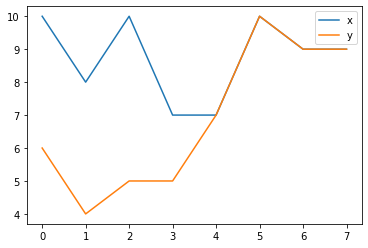

In [345]:
df = pd.DataFrame({'x': [10, 8, 10, 7, 7, 10, 9, 9],
 'y': [6, 4, 5, 5, 7, 10, 9, 9]})

df.plot()

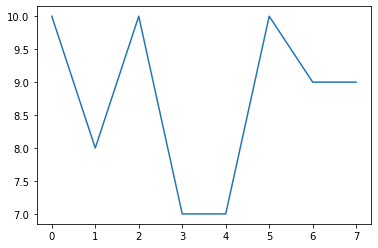

In [346]:
# You can call the same method for a Series object to plot a subset of the Data Frame:
df['x'].plot()

**Bar Chart**

If you want to explore the distribution of your data, you can use the hist() method.

array([[<matplotlib.axes._subplots.AxesSubplot object at 0x7f97365b8a30>,
      dtype=object)

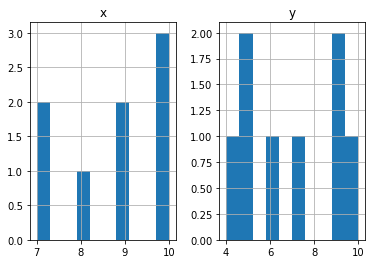

In [348]:
df.hist()

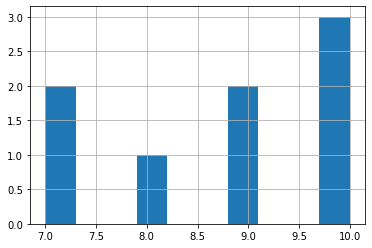

In [349]:
df['x'].hist()

**General method for plotting plot()**

All the possible graphs are available through the plot method. The kind of chart is selected by the
kind argument.

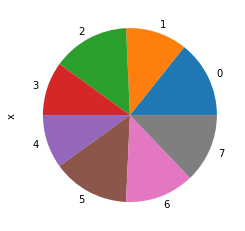

In [352]:
df['x'].plot(kind='pie')

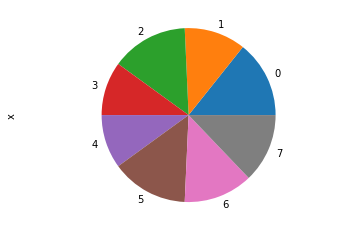

In [353]:
# Note In many environments, the pie chart will come out an oval. To make it a circle, use the following:
from matplotlib import pyplot
pyplot.axis('equal')
df['x'].plot(kind='pie')

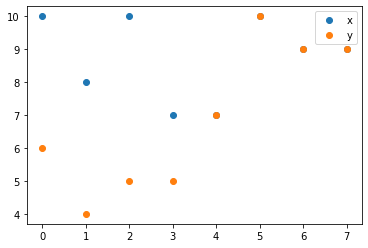

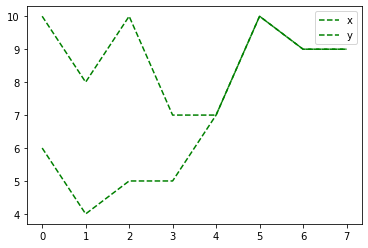

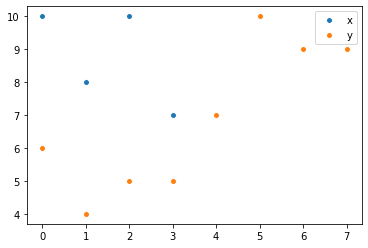

In [354]:
# Styling the plot
# plot() can take arguments that get passed on to matplotlib to style the plot in different ways.
df.plot(style='o') # plot as dots, not lines
df.plot(style='g--') # plot as green dashed line
df.plot(style='o', markeredgecolor='white') # plot as dots with white edge

**Plot on an existing matplotlib axis**

By default, plot() creates a new figure each time it is called. It is possible to plot on an existing
axis by passing the ax parameter.

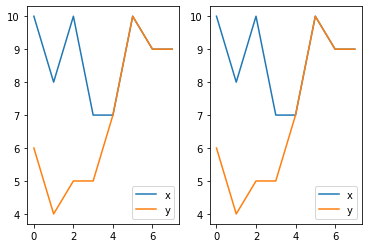

In [360]:
plt.figure() # create a new figure
ax = plt.subplot(121) # create the left-side subplot
df.plot(ax=ax) # plot df1 on that subplot
ax = plt.subplot(122) # create the right-side subplot
df.plot(ax=ax) # and plot df2 there
plt.show() # show the plot

# Chapter 15: Grouping Data

In [363]:
# Basic grouping Group by one column
df = pd.DataFrame({'A': ['a', 'b', 'c', 'a', 'b', 'b'],
 'B': [2, 8, 1, 4, 3, 8],
 'C': [102, 98, 107, 104, 115, 87]})
df

,A,B,C
0,a,2,102
1,b,8,98
2,c,1,107
3,a,4,104
4,b,3,115
5,b,8,87


In [366]:
# Group by column A and get the mean value of other columns:
df.groupby('A').mean()

,B,C
A,,
a,3.000000,103.0
b,6.333333,100.0
c,1.000000,107.0


In [369]:
# Group by multiple columns
df.groupby(['A','B']).mean()

C
A B       
a 2  102.0
  4  104.0
b 3  115.0
  8   92.5
c 1  107.0

Note how after grouping each row in the resulting DataFrame is indexed by a tuple or MultiIndex
(in this case a pair of elements from columns A and B).

To apply several aggregation methods at once, for instance to count the number of items in each
group and compute their mean, use the agg function:

In [371]:
df.groupby(['A','B']).agg(['count','mean'])

C       
    count   mean
A B             
a 2     1  102.0
  4     1  104.0
b 3     1  115.0
  8     2   92.5
c 1     1  107.0

In [375]:
# Grouping numbers

import numpy as np
import pandas as pd
np.random.seed(0)
df = pd.DataFrame({'Age':np.random.randint(20,70,100), # random integer start from 20 to 79 with total 100
                   'Sex':np.random.choice(['Male','Female'],100),
                   'number_of_foo':np.random.randint(1,20,100)})
df.head()

,Age,Sex,number_of_foo
0,64,Female,14
1,67,Female,14
2,20,Female,12
3,23,Male,17
4,23,Female,15


Group Age into three categories (or bins). Bins can be given as

- an integer n indicating the number of bins—in this case the dataframe's data is divided into n
intervals of equal size

- a sequence of integers denoting the endpoint of the left-open intervals in which the data is
divided into—for instance bins=[19, 40, 65, np.inf] creates three age groups (19, 40], (40,
65], and (65, np.inf].

Pandas assigns automatically the string versions of the intervals as label. It is also possible to
define own labels by defining a labels parameter as a list of strings.

In [374]:
pd.cut(df['Age'], bins=4)
# this creates four age groups: (19.951, 32.25] < (32.25, 44.5] < (44.5, 56.75] < (56.75, 69]

0       (56.75, 69.0]
1       (56.75, 69.0]
2     (19.951, 32.25]
3     (19.951, 32.25]
4     (19.951, 32.25]
           ...       
95      (32.25, 44.5]
96      (32.25, 44.5]
97      (32.25, 44.5]
98      (56.75, 69.0]
99      (56.75, 69.0]
Name: Age, Length: 100, dtype: category
Categories (4, interval[float64]): [(19.951, 32.25] < (32.25, 44.5] < (44.5, 56.75] < (56.75, 69.0]]

In [376]:
pd.cut(df['Age'], bins=[19, 40, 65, np.inf])
# this creates three age groups: (19, 40], (40, 65] and (65, infinity)

0     (40.0, 65.0]
1      (65.0, inf]
2     (19.0, 40.0]
3     (19.0, 40.0]
4     (19.0, 40.0]
          ...     
95    (19.0, 40.0]
96    (19.0, 40.0]
97    (40.0, 65.0]
98     (65.0, inf]
99     (65.0, inf]
Name: Age, Length: 100, dtype: category
Categories (3, interval[float64]): [(19.0, 40.0] < (40.0, 65.0] < (65.0, inf]]

In [378]:
# Use it in groupby to get the mean number of foo:
age_groups = pd.cut(df['Age'], bins=[19,40,65,np.inf])
df.groupby(age_groups)['number_of_foo'].mean()

Age
(19.0, 40.0]    9.880000
(40.0, 65.0]    9.452381
(65.0, inf]     9.250000
Name: number_of_foo, dtype: float64

In [379]:
df.groupby(age_groups).mean()

,Age,number_of_foo
Age,,
"(19.0, 40.0]",29.840000,9.880000
"(40.0, 65.0]",52.833333,9.452381
"(65.0, inf]",67.375000,9.250000


In [380]:
# Cross tabulate age groups and gender:
pd.crosstab(age_groups, df['Sex'])

Sex,Female,Male
Age,,
"(19.0, 40.0]",22,28
"(40.0, 65.0]",18,24
"(65.0, inf]",3,5


In [388]:
# Column selection of a group
# When you do a groupby you can select either a single column or a list of columns:
df = pd.DataFrame([[1,2,3],[1,7,8],[8,5,4]],columns=["A","B","C"])
df

,A,B,C
0,1,2,3
1,1,7,8
2,8,5,4


In [389]:
g = df.groupby('A')

In [391]:
g['B'].mean()

A
1    4.5
8    5.0
Name: B, dtype: float64

In [395]:
g["B","C"].mean()

<ipython-input-395-0f75ce6a7d66>:1: FutureWarning: Indexing with multiple keys (implicitly converted to a tuple of keys) will be deprecated, use a list instead.
  g["B","C"].mean()


,B,C
A,,
1,4.5,5.5
8,5.0,4.0


In [397]:
g[["B","C"]].mean()

,B,C
A,,
1,4.5,5.5
8,5.0,4.0


In [399]:
# You can also use agg to specify columns and aggregation to perform:
g[["B","C"]].agg(["count","mean"])

B          C     
  count mean count mean
A                      
1     2  4.5     2  5.5
8     1  5.0     1  4.0

In [402]:
g.agg({"B":"mean","C":"count"})

,B,C
A,,
1,4.5,2
8,5.0,1


**Aggregating by size versus by count**

The difference between size and count is:
size counts NaN values, count does not.

In [404]:
df = pd.DataFrame(
 {"Name":["Alice", "Bob", "Mallory", "Mallory", "Bob" , "Mallory"],
 "City":["Seattle", "Seattle", "Portland", "Seattle", "Seattle", "Portland"],
 "Val": [4, 3, 3, np.nan, np.nan, 4]})

df

,Name,City,Val
0,Alice,Seattle,4.0
1,Bob,Seattle,3.0
2,Mallory,Portland,3.0
3,Mallory,Seattle,NaN
4,Bob,Seattle,NaN
5,Mallory,Portland,4.0


In [411]:
df.groupby(["Name","City"])["Val"].size().reset_index(name='Size')

,Name,City,Size
0,Alice,Seattle,1
1,Bob,Seattle,2
2,Mallory,Portland,2
3,Mallory,Seattle,1


In [412]:
df.groupby(['Name','City'])["Val"].count().reset_index(name='Count')

,Name,City,Count
0,Alice,Seattle,1
1,Bob,Seattle,1
2,Mallory,Portland,2
3,Mallory,Seattle,0


**Aggregating groups**

In [444]:
import numpy as np
import pandas as pd
df = pd.DataFrame({'A': list('XYZXYZXYZX'), 'B': [1, 2, 1, 3, 1, 2, 3, 3, 1, 2],
 'C': [12, 14, 11, 12, 13, 14, 16, 12, 10, 19]})

df.groupby('A')['B'].agg([np.mean,np.std])
df.groupby('A')['B'].agg(Avg=np.mean,Std=np.std)


,Avg,Std
A,,
X,2.250000,0.957427
Y,2.000000,1.000000
Z,1.333333,0.577350


In [447]:
# For multiple columns:
df.groupby('A').agg({'B': [np.mean, np.std], 'C': [np.sum, 'count']})

B             C      
       mean       std sum count
A                              
X  2.250000  0.957427  59     4
Y  2.000000  1.000000  39     3
Z  1.333333  0.577350  35     3

In [452]:
# Export groups in different files
# You can iterate on the object returned by groupby(). The iterator contains (Category, DataFrame) tuples.
# Same example data as in the previous example.

import numpy as np
import pandas as pd
np.random.seed(0)
df = pd.DataFrame({'Age': np.random.randint(20, 70, 100),
                   'Sex': np.random.choice(['Male', 'Female'], 100),
                   'number_of_foo': np.random.randint(1, 20, 100)})

# Export to Male.csv and Female.csv files.
for sex, data in df.groupby('Sex'):
 data.to_csv("{}.csv".format(sex)) # create 2 files name "Male" and "Female"


In [454]:
# using transform to get group-level statistics while preserving the original dataframe
# example:

df = pd.DataFrame({'group1' : ['A', 'A', 'A', 'A','B', 'B', 'B', 'B'],
                   'group2' : ['C', 'C', 'C', 'D','E', 'E', 'F', 'F'],
                   'B'      : ['one', np.NaN, np.NaN, np.NaN, np.NaN, 'two', np.NaN, np.NaN],
                   'C'      : [np.NaN, 1, np.NaN, np.NaN,np.NaN, np.NaN, np.NaN, 4]})
df

,group1,group2,B,C
0,A,C,one,NaN
1,A,C,NaN,1.0
2,A,C,NaN,NaN
3,A,D,NaN,NaN
4,B,E,NaN,NaN
5,B,E,two,NaN
6,B,F,NaN,NaN
7,B,F,NaN,4.0


**I want to get the count of non-missing observations of B for each combination of group1 and group2.**

**groupby.transform is a very powerful function that does exactly that.**

In [456]:
df['count_B']=df.groupby(['group1','group2']).B.transform('count')
df

,group1,group2,B,C,count_B
0,A,C,one,NaN,1
1,A,C,NaN,1.0,1
2,A,C,NaN,NaN,1
3,A,D,NaN,NaN,0
4,B,E,NaN,NaN,1
5,B,E,two,NaN,1
6,B,F,NaN,NaN,0
7,B,F,NaN,4.0,0


In [458]:
df['count_C'] = df.groupby(['group1','group2'])['C'].transform('count')
df

,group1,group2,B,C,count_B,count_C
0,A,C,one,NaN,1,1
1,A,C,NaN,1.0,1,1
2,A,C,NaN,NaN,1,1
3,A,D,NaN,NaN,0,0
4,B,E,NaN,NaN,1,0
5,B,E,two,NaN,1,0
6,B,F,NaN,NaN,0,1
7,B,F,NaN,4.0,0,1


# Chapter 16: Grouping Time Series Data

Generate time series of random numbers then down sample


In [459]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

# I want 7 days of 24 hours with 60 minutes each
periods = 7 * 24 * 60
tidx = pd.date_range('2016-07-01', periods=periods, freq='T')
#                          ^                              ^
#                          |                              |
#                     Start Date            Frequency Code for Minute
# This should get me 7 Days worth of minutes in a datetimeindex
# Generate random data with numpy. We'll seed the random
# number generator so that others can see the same results.
# Otherwise, you don't have to seed it.
np.random.seed([3,1415])
# This will pick a number of normally distributed random numbers
# where the number is specified by periods
data = np.random.randn(periods)
ts = pd.Series(data=data, index=tidx, name='HelloTimeSeries')
ts.describe()

count    10080.000000
mean        -0.008853
std          0.995411
min         -3.936794
25%         -0.683442
50%          0.002640
75%          0.654986
max          3.906053
Name: HelloTimeSeries, dtype: float64

Let's take this 7 days of per minute data and down sample to every 15 minutes. All frequency
codes can be found here.

In [460]:
# resample says to group by every 15 minutes. But now we need
# to specify what to do within those 15 minute chunks.
# We could take the last value.
ts.resample('15T').last()

2016-07-01 00:00:00   -0.911575
2016-07-01 00:15:00    0.831452
2016-07-01 00:30:00    1.258253
2016-07-01 00:45:00   -0.017209
2016-07-01 01:00:00    0.025249
                         ...   
2016-07-07 22:45:00   -0.112963
2016-07-07 23:00:00   -1.684835
2016-07-07 23:15:00   -0.268678
2016-07-07 23:30:00    1.097568
2016-07-07 23:45:00   -0.543848
Freq: 15T, Name: HelloTimeSeries, Length: 672, dtype: float64

Or any other thing we can do to a groupby object, documentation.
We can even aggregate several useful things. Let's plot the min, mean, and max of this
resample('15M') data.

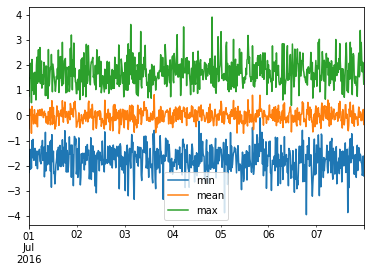

In [461]:
ts.resample('15T').agg(['min', 'mean', 'max']).plot()

Let's resample over '15T' (15 minutes), '30T' (half hour), and '1H' (1 hour) and see how our data
gets smoother.

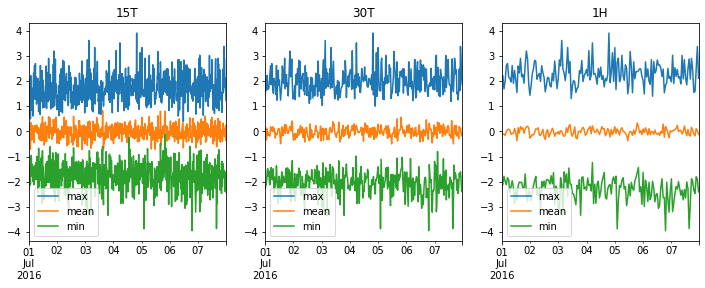

In [462]:
fig, axes = plt.subplots(1, 3, figsize=(12, 4))
for i, freq in enumerate(['15T', '30T', '1H']):
 ts.resample(freq).agg(['max', 'mean', 'min']).plot(ax=axes[i], title=freq)

# Chapter 17: Holiday Calendars

Create a custom calendar
Here is how to create a custom calendar. The example given is a french calendar -- so it provides
many examples.

In [463]:
from pandas.tseries.holiday import AbstractHolidayCalendar, Holiday, EasterMonday, Easter
from pandas.tseries.offsets import Day, CustomBusinessDay
class FrBusinessCalendar(AbstractHolidayCalendar):
 """ Custom Holiday calendar for France based on
 https://en.wikipedia.org/wiki/Public_holidays_in_France
 - 1 January: New Year's Day
 - Moveable: Easter Monday (Monday after Easter Sunday)
 - 1 May: Labour Day
 - 8 May: Victory in Europe Day
 - Moveable Ascension Day (Thursday, 39 days after Easter Sunday)
 - 14 July: Bastille Day
 - 15 August: Assumption of Mary to Heaven
 - 1 November: All Saints' Day
 - 11 November: Armistice Day
 - 25 December: Christmas Day
 """
 rules = [
 Holiday('New Years Day', month=1, day=1),
 EasterMonday,
 Holiday('Labour Day', month=5, day=1),
 Holiday('Victory in Europe Day', month=5, day=8),
 Holiday('Ascension Day', month=1, day=1, offset=[Easter(), Day(39)]),
 Holiday('Bastille Day', month=7, day=14),
 Holiday('Assumption of Mary to Heaven', month=8, day=15),
 Holiday('All Saints Day', month=11, day=1),
 Holiday('Armistice Day', month=11, day=11),
 Holiday('Christmas Day', month=12, day=25)
 ]

Use a custom calendar

Here is how to use the custom calendar.

Get the holidays between two dates

In [465]:
import pandas as pd
from datetime import date
# Creating some boundaries
year = 2016
start = date(year, 1, 1)

end = start + pd.offsets.MonthEnd(12)
# Creating a custom calendar
cal = FrBusinessCalendar()
# Getting the holidays (off-days) between two dates
cal.holidays(start=start, end=end)

DatetimeIndex(['2016-01-01', '2016-03-28', '2016-05-01', '2016-05-05',
               '2016-05-08', '2016-07-14', '2016-08-15', '2016-11-01',
               '2016-11-11', '2016-12-25'],
              dtype='datetime64[ns]', freq=None)

**Count the number of working days between two dates**

It is sometimes useful to get the number of working days by month whatever the year in the future
or in the past. Here is how to do that with a custom calendar.

In [466]:
from pandas.tseries.offsets import CDay
# Creating a series of dates between the boundaries
# by using the custom calendar
se = pd.bdate_range(start=start,end=end,freq=CDay(calendar=cal)).to_series()
# Counting the number of working days by month
se.groupby(se.dt.month).count().head()

1    20
2    21
3    22
4    21
5    21
dtype: int64

# Chapter 18: Indexing and selecting data

**Select column by label**

In [468]:
# Create a sample DF
df = pd.DataFrame(np.random.randn(5, 3), columns=list('ABC'))
# Show DF
df

,A,B,C
0,2.059591,-0.379065,-0.135415
1,0.913717,0.287985,-0.134038
2,0.020426,1.407537,-0.002103
3,-0.248215,0.416876,-0.984787
4,-0.743571,0.010867,-1.649587


In [469]:
# Select column using a single label, 'A'
df['A']

0    2.059591
1    0.913717
2    0.020426
3   -0.248215
4   -0.743571
Name: A, dtype: float64

In [472]:
# Select multiple columns using an array of labels, ['A', 'C']
df[['A', 'C']]

,A,C
0,2.059591,-0.135415
1,0.913717,-0.134038
2,0.020426,-0.002103
3,-0.248215,-0.984787
4,-0.743571,-1.649587


**Select by position**

The iloc (short for integer location) method allows to select the rows of a dataframe based on their
position index. This way one can slice dataframes just like one does with Python's list slicing.


In [473]:
df = pd.DataFrame([[11, 22], [33, 44], [55, 66]], index=list("abc"))
df

,0,1
a,11,22
b,33,44
c,55,66


In [474]:
df.iloc[0] # the 0th index (row)

0    11
1    22
Name: a, dtype: int64

In [475]:
df.iloc[1] # the 1st index (row

0    33
1    44
Name: b, dtype: int64

In [476]:
df.iloc[:2] # the first 2 rows

,0,1
a,11,22
b,33,44


In [477]:
df[::-1] # reverse order of rows

,0,1
c,55,66
b,33,44
a,11,22


**Row location can be combined with column location**

In [478]:
df.iloc[:, 1] # the 1st column

a    22
b    44
c    66
Name: 1, dtype: int64

**Slicing with labels**

When using labels, both the start and the stop are included in the results.

In [480]:
import pandas as pd
import numpy as np

np.random.seed(5)
df = pd.DataFrame(np.random.randint(100, size=(5, 5)), columns = list("ABCDE"),
 index = ["R" + str(i) for i in range(5)])

df

,A,B,C,D,E
R0,99,78,61,16,73
R1,8,62,27,30,80
R2,7,76,15,53,80
R3,27,44,77,75,65
R4,47,30,84,86,18


In [481]:
# Rows R0 to R2:
df.loc['R0':'R2']

,A,B,C,D,E
R0,99,78,61,16,73
R1,8,62,27,30,80
R2,7,76,15,53,80


In [482]:
# Notice how loc differs from iloc because iloc excludes the end index
df.iloc[0:2] # rows indexed by 0, 1

,A,B,C,D,E
R0,99,78,61,16,73
R1,8,62,27,30,80


In [483]:
# Columns C to E:
df.loc[:, 'C':'E']

,C,D,E
R0,61,16,73
R1,27,30,80
R2,15,53,80
R3,77,75,65
R4,84,86,18


In [484]:
# Mixed position and label based selection
# DataFrame:
import pandas as pd
import numpy as np
np.random.seed(5)
df = pd.DataFrame(np.random.randint(100, size=(5, 5)), columns = list("ABCDE"),
 index = ["R" + str(i) for i in range(5)])
df

,A,B,C,D,E
R0,99,78,61,16,73
R1,8,62,27,30,80
R2,7,76,15,53,80
R3,27,44,77,75,65
R4,47,30,84,86,18


In [488]:
# Select rows by position, and columns by label:
df.ix[1:3, 'C':'E']

AttributeError: 'DataFrame' object has no attribute 'ix'

In [489]:
# If the index is integer, .ix will use labels rather than positions:
df.index = np.arange(5, 10)
df

,A,B,C,D,E
5,99,78,61,16,73
6,8,62,27,30,80
7,7,76,15,53,80
8,27,44,77,75,65
9,47,30,84,86,18


In [490]:
#same call returns an empty DataFrame because now the index is integer
df.ix[1:3, 'C':'E']

AttributeError: 'DataFrame' object has no attribute 'ix'

In [491]:
# Boolean indexing
# One can select rows and columns of a dataframe using boolean arrays.
import pandas as pd
import numpy as np
np.random.seed(5)
df = pd.DataFrame(np.random.randint(100, size=(5, 5)), columns = list("ABCDE"),
 index = ["R" + str(i) for i in range(5)])
print (df)

     A   B   C   D   E
R0  99  78  61  16  73
R1   8  62  27  30  80
R2   7  76  15  53  80
R3  27  44  77  75  65
R4  47  30  84  86  18


In [492]:
mask = df['A'] > 10
print (mask)

R0     True
R1    False
R2    False
R3     True
R4     True
Name: A, dtype: bool


In [493]:
print (df[mask])

     A   B   C   D   E
R0  99  78  61  16  73
R3  27  44  77  75  65
R4  47  30  84  86  18


In [494]:
print (df.ix[mask, 'C'])

AttributeError: 'DataFrame' object has no attribute 'ix'

In [495]:
print(df.ix[mask, ['C', 'D']])

AttributeError: 'DataFrame' object has no attribute 'ix'

**Filtering columns (selecting "interesting", dropping unneeded, using RegEx,
etc.)**

generate sample DF

In [496]:
df = pd.DataFrame(np.random.randint(0, 10, size=(5, 6)),columns=['a10','a20','a25','b','c','d'])
df

,a10,a20,a25,b,c,d
0,9,9,9,9,1,2
1,7,0,5,0,0,4
2,4,9,3,2,4,6
3,9,3,3,2,1,5
4,7,4,3,1,7,3


In [497]:
# show columns containing letter 'a'
df.filter(like='a')

,a10,a20,a25
0,9,9,9
1,7,0,5
2,4,9,3
3,9,3,3
4,7,4,3


In [499]:
# show columns using RegEx filter (b|c|d) - b or c or d:
df.filter(regex='(b|c|d)')

,b,c,d
0,9,1,2
1,0,0,4
2,2,4,6
3,2,1,5
4,1,7,3


In [501]:
# show all columns except those beginning with a (in other word remove / drop all columns satisfying given RegEx)
df.iloc[:, ~df.columns.str.contains('^a')]

,b,c,d
0,9,1,2
1,0,0,4
2,2,4,6
3,2,1,5
4,1,7,3


In [502]:
# Filtering / selecting rows using `.query()` method
import pandas as pd
# generate random DF
df = pd.DataFrame(np.random.randint(0,10,size=(10, 3)), columns=list('ABC'))
print(df)

   A  B  C
0  1  9  5
1  7  0  9
2  6  0  5
3  2  8  6
4  8  0  5
5  2  0  7
6  7  6  0
7  0  8  5
8  5  9  6
9  4  5  2


**select rows where values in column A > 2 and values in column B < 5**

In [503]:
df.query('A > 2 and B < 5')

,A,B,C
1,7,0,9
2,6,0,5
4,8,0,5


**using .query() method with variables for filtering**

In [509]:
A_filter = [1,7]
df.query('A == @A_filter')

,A,B,C
0,1,9,5
1,7,0,9
6,7,6,0


In [510]:
df.query('@A_filter in A')

,A,B,C
0,1,9,5
1,7,0,9
6,7,6,0


**Path Dependent Slicing**

It may become necessary to traverse the elements of a series or the rows of a dataframe in a way
that the next element or next row is dependent on the previously selected element or row. 
This is called path dependency.
Consider the following time series s with irregular frequency.

In [573]:
#starting python community conventions
import numpy as np
import pandas as pd
# n is number of observations
n = 5000
day = pd.to_datetime(['2013-02-06'])
# irregular seconds spanning 28800 seconds (8 hours)
seconds = np.random.rand(n) * 28800 * pd.Timedelta(1, 's')
# start at 8 am
start = pd.offsets.Hour(8)


In [534]:
print(seconds)

[18718485800934  8949693750798 19209817467439 ... 20609881180581
  3255311803310  7731876738912]


In [518]:
pd.Timedelta(1, 's')

Timedelta('0 days 00:00:01')

In [523]:
day

DatetimeIndex(['2013-02-06'], dtype='datetime64[ns]', freq=None)

In [524]:
start

<8 * Hours>

In [586]:
rnd = np.random.rand(n) * 28800 * pd.Timedelta(1, 's')
for x in rnd:    
    tidx = day + start + x
    #print(tidx)
    #tidx = tidx.sort_values()
#s = pd.Series(np.random.randn(n), tidx, name='A').cumsum()
type(tidx)

pandas.core.indexes.datetimes.DatetimeIndex

In [ ]:
# irregular timeseries
#tidx = day + start + seconds[0]
tidx = tidx.sort_values()

s = pd.Series(np.random.randn(n), tidx, name='A').cumsum()
s.plot();

Let's assume a path dependent condition. Starting with the first member of the series, I want to
grab each subsequent element such that the absolute difference between that element and the
current element is greater than or equal to x.
We'll solve this problem using python generators.

**Generator function**

In [592]:
def mover(s, move_size=10):
    """Given a reference, find next value with an absolute difference >= move_size"""
ref = None
for i, v in s.iteritems():
    if ref is None or (abs(ref - v) >= move_size):
        yield i, v
        ref = v

SyntaxError: 'yield' outside function (<ipython-input-592-c9a348081088>, line 6)

In [ ]:
#Then we can define a new series moves like so
moves = pd.Series({i:v for i, v in mover(s, move_size=10)},name='_{}_'.format(s.name))
#Plotting them both
moves.plot(legend=True)
s.plot(legend=True)

In [ ]:
# The analog for dataframes would be:
def mover_df(df, col, move_size=2):
    ref = None
    for i, row in df.iterrows():
        if ref is None or (abs(ref - row.loc[col]) >= move_size):
            yield row
            ref = row.loc[col]

df = s.to_frame()
moves_df = pd.concat(mover_df(df, 'A', 10), axis=1).T
moves_df.A.plot(label='_A_', legend=True)
df.A.plot(legend=True)

Get the first/last n rows of a dataframe
To view the first or last few records of a dataframe, you can use the methods head and tail
To return the first n rows use DataFrame.head([n])


In [595]:
df.head(n)

,0
0,a
1,b
2,c
3,a
4,b


In [596]:
#To return the last n rows use DataFrame.tail([n])
df.tail(n)
#Without the argument n, these functions return 5 rows.
#Note that the slice notation for head/tail would be:
df[:10] # same as df.head(10)
df[-10:] # same as df.tail(10)
#Select distinct rows across dataframe
#Let
df = pd.DataFrame({'col_1':['A','B','A','B','C'], 'col_2':[3,4,3,5,6]})
df

,col_1,col_2
0,A,3
1,B,4
2,A,3
3,B,5
4,C,6


In [598]:
# To get the distinct values in col_1 you can use Series.unique()
df['col_1'].unique()
# Output:
# array(['A', 'B', 'C'], dtype=object)
# But Series.unique() works only for a single column.


array(['A', 'B', 'C'], dtype=object)

In [599]:
#To simulate the select unique col_1, col_2 of SQL you can use DataFrame.drop_duplicates():
df.drop_duplicates()

,col_1,col_2
0,A,3
1,B,4
3,B,5
4,C,6


In [600]:
#This will get you all the unique rows in the dataframe. So if
df = pd.DataFrame({'col_1':['A','B','A','B','C'], 'col_2':[3,4,3,5,6],'col_3':[0,0.1,0.2,0.3,0.4]})
df

,col_1,col_2,col_3
0,A,3,0.0
1,B,4,0.1
2,A,3,0.2
3,B,5,0.3
4,C,6,0.4


In [601]:
#To specify the columns to consider when selecting unique records, pass them as arguments
df = pd.DataFrame({'col_1':['A','B','A','B','C'], 'col_2':[3,4,3,5,6],'col_3':[0,0.1,0.2,0.3,0.4]})
df.drop_duplicates(['col_1','col_2'])

,col_1,col_2,col_3
0,A,3,0.0
1,B,4,0.1
3,B,5,0.3
4,C,6,0.4


In [602]:
# Filter out rows with missing data (NaN, None, NaT)
# If you have a dataframe with missing data (NaN, pd.NaT, None) you can filter out incomplete rows
df = pd.DataFrame([[0,1,2,3],
 [None,5,None,pd.NaT],
 [8,None,10,None],
 [11,12,13,pd.NaT]],columns=list('ABCD'))
df

,A,B,C,D
0,0.0,1.0,2.0,3
1,NaN,5.0,NaN,NaT
2,8.0,NaN,10.0,None
3,11.0,12.0,13.0,NaT


In [603]:
# DataFrame.dropna drops all rows containing at least one field with missing data
df.dropna()

,A,B,C,D
0,0.0,1.0,2.0,3


In [604]:
# To just drop the rows that are missing data at specified columns use subset
df.dropna(subset=['C'])

,A,B,C,D
0,0.0,1.0,2.0,3
2,8.0,NaN,10.0,None
3,11.0,12.0,13.0,NaT


Use the option inplace = True for in-place replacement with the filtered frame.

# Chapter 21: Making Pandas Play Nice With Native Python Datatypes

In [605]:
# Moving Data Out of Pandas Into Native Python and Numpy Data Structures
df = pd.DataFrame({'A': [1, 2, 3], 'B': [1.0, 2.0, 3.0], 'C': ['a', 'b', 'c'],
 'D': [True, False, True]})

df

,A,B,C,D
0,1,1.0,a,True
1,2,2.0,b,False
2,3,3.0,c,True


In [606]:
# Getting a python list from a series:
df['A'].tolist()

[1, 2, 3]

In [608]:
# Getting a numpy array from a series:
df['B'].values

array([1., 2., 3.])

In [609]:
#You can also get an array of the columns as individual numpy arrays from an entire dataframe:
df.values

array([[1, 1.0, 'a', True],
       [2, 2.0, 'b', False],
       [3, 3.0, 'c', True]], dtype=object)

In [611]:
# Getting a dictionary from a series (uses the index as the keys):
df['C'].to_dict()

{0: 'a', 1: 'b', 2: 'c'}

In [613]:
# You can also get the entire DataFrame back as a dictionary:
df.to_dict()

{'A': {0: 1, 1: 2, 2: 3},
 'B': {0: 1.0, 1: 2.0, 2: 3.0},
 'C': {0: 'a', 1: 'b', 2: 'c'},
 'D': {0: True, 1: False, 2: True}}

In [614]:
# The to_dict method has a few different parameters to adjust how the dictionaries are formatted.
# To get a list of dicts for each row:
df.to_dict('record')

[{'A': 1, 'B': 1.0, 'C': 'a', 'D': True},
 {'A': 2, 'B': 2.0, 'C': 'b', 'D': False},
 {'A': 3, 'B': 3.0, 'C': 'c', 'D': True}]

# Chapter 22: Map Values

It should be mentioned that if the key value does not exist then this will raise KeyError, in those
situations it maybe better to use merge or get which allows you to specify a default value if the key
doesn't exist

**Map from Dictionary**

In [649]:
df = pd.DataFrame(columns = ['U','L'])
df.loc[0] = [111,112,112,113,113,113,114]
df.loc[1] = ['en','en','es','es','ja','zh','es']
df



ValueError: cannot set a row with mismatched columns

In [663]:
#df2 = pd.DataFrame([111,112,112,113,113,113,114],['en','en','es','es','ja','zh','es'])
#df2

df = pd.DataFrame({'U':[111,112,112,113,113,113,114],"L":['en','en','es','es','ja','zh','es']})
df

,U,L
0,111,en
1,112,en
2,112,es
3,113,es
4,113,ja
5,113,zh
6,114,es


In [668]:
# Imagine you want to add a new column called S taking values from the following dictionary:
d = {112: 'en', 113: 'es', 114: 'es', 111: 'en'}

# You can use map to perform a lookup on keys returning the corresponding values as a new column:
df['S'] = df['U'].map(d)
df

,U,L,S
0,111,en,en
1,112,en,en
2,112,es,en
3,113,es,es
4,113,ja,es
5,113,zh,es
6,114,es,es


# Chapter 23: Merge, join, and concatenate

**Syntax**

• DataFrame.merge(right, how='inner', on=None, left_on=None, right_on=None, left_index=False, right_index=False, sort=False, suffixes=('_x', '_y'), copy=True, indicator=False)

• Merge DataFrame objects by performing a database-style join operation by columns or indexes.

• If joining columns on columns, the DataFrame indexes will be ignored. Otherwise if joining indexes on indexes or indexes on a column or columns, the index will be passed on.

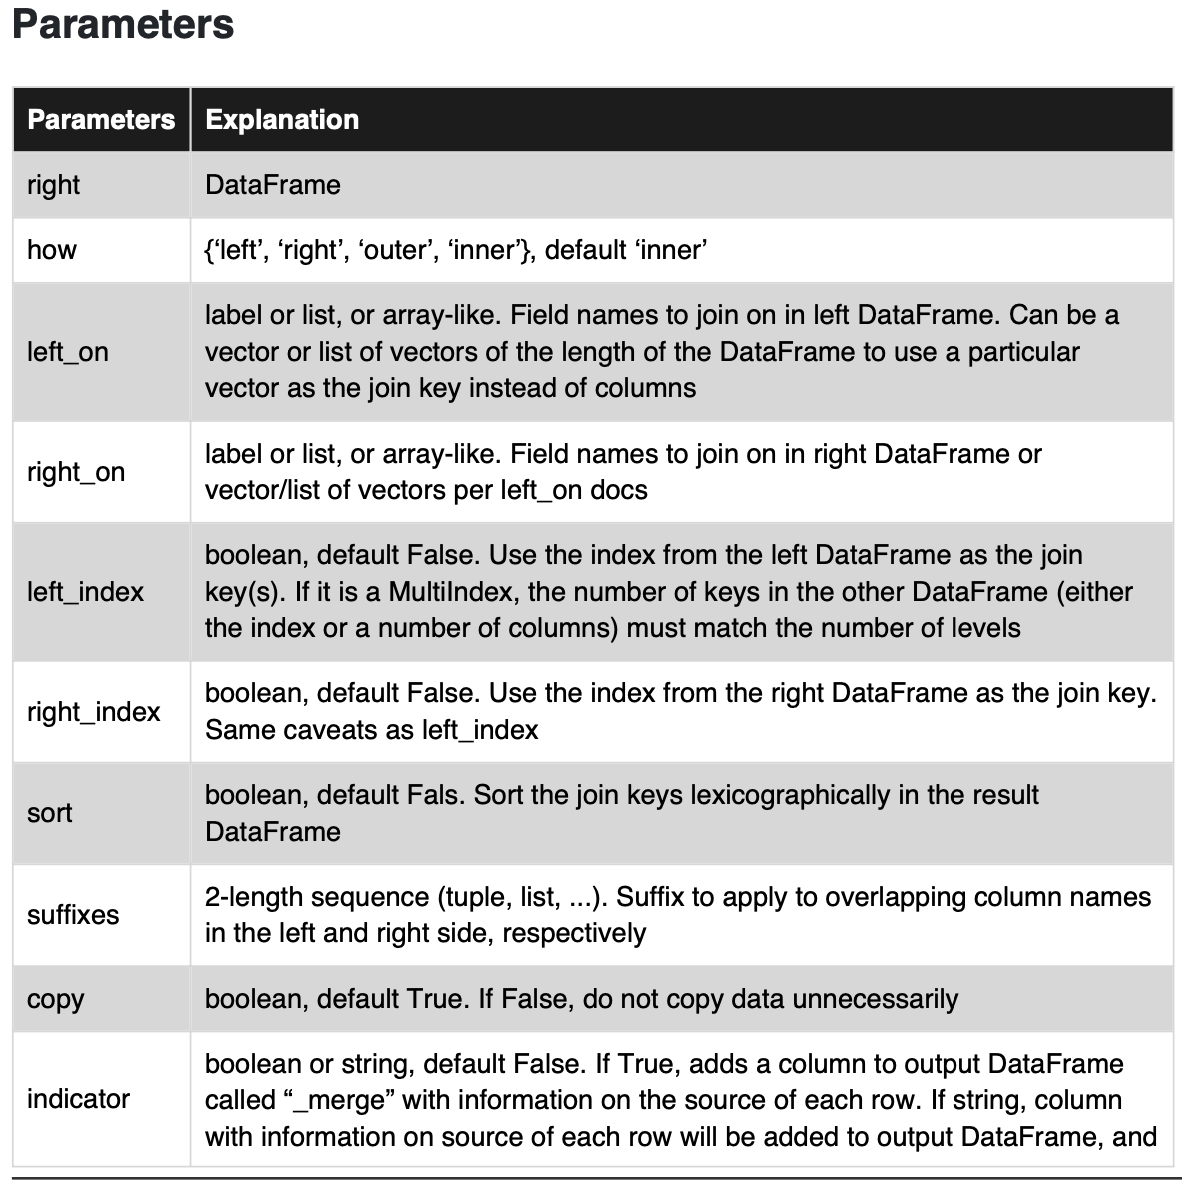

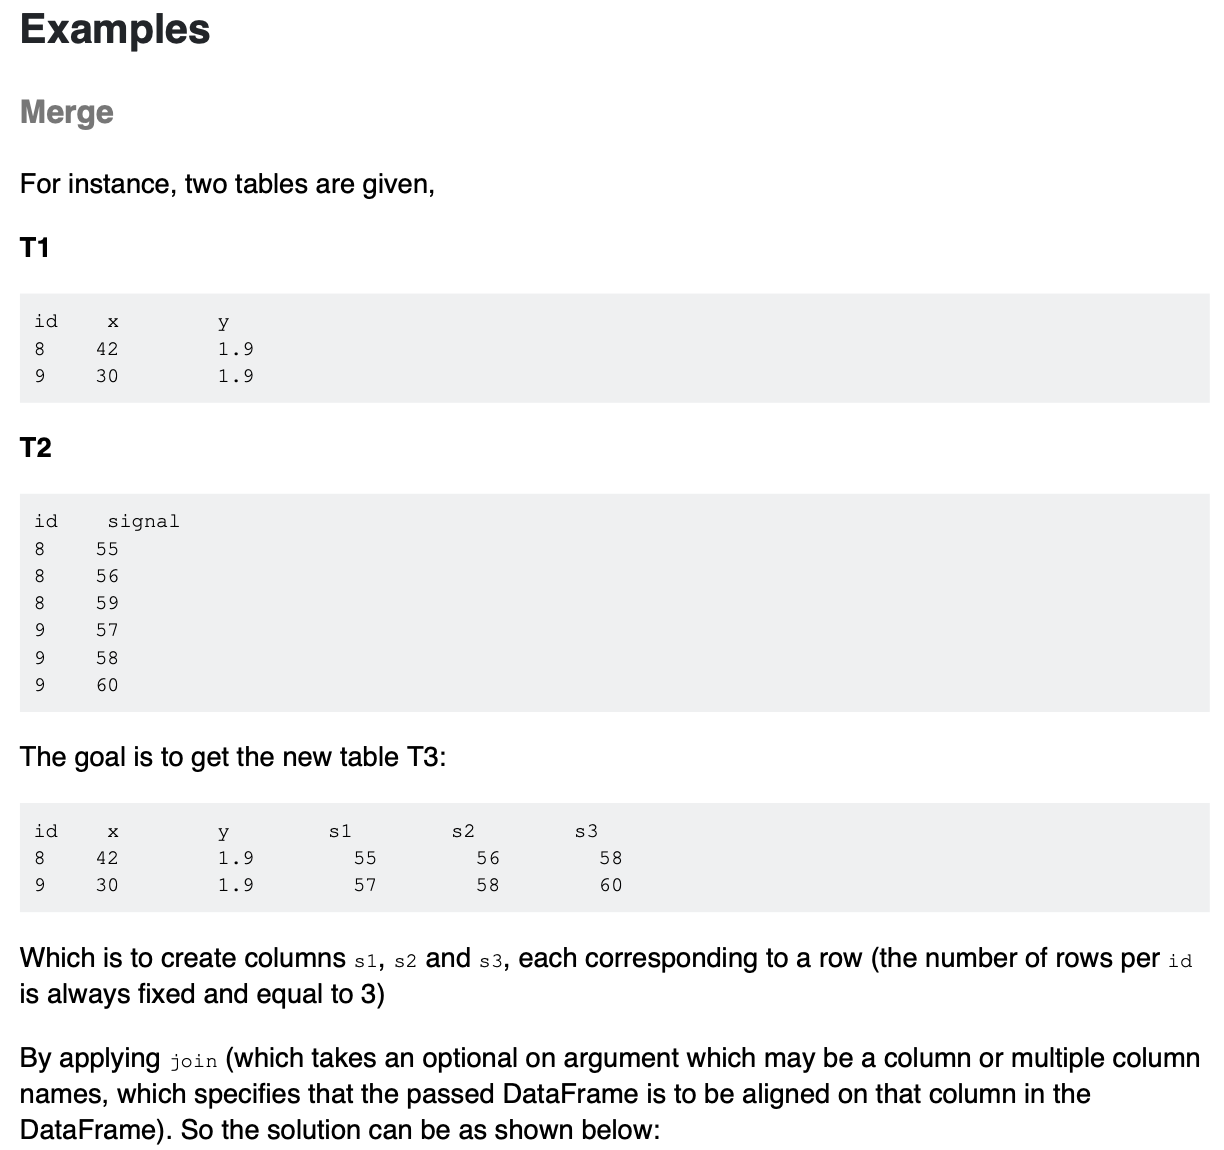

In [2]:
import pandas as pd
T1 = pd.DataFrame({'id': [8, 9], 
                   'x': [42, 30], 
                   'y': [1.9, 1.9]
                  })

T2 = pd.DataFrame({'id':[8,8,8,9,9,9],
                   'signal' :[55,56,59,57,58,60] 
                  })


In [3]:
T1

,id,x,y
0,8,42,1.9
1,9,30,1.9


In [4]:
T2

,id,signal
0,8,55
1,8,56
2,8,59
3,9,57
4,9,58
5,9,60


In [9]:
df = T1.merge(T2.groupby('id')['signal'].apply(lambda x:x.reset_index(drop=True)).reset_index())
df

,id,x,y,level_1,signal
0,8,42,1.9,0,55
1,8,42,1.9,1,56
2,8,42,1.9,2,59
3,9,30,1.9,0,57
4,9,30,1.9,1,58
5,9,30,1.9,2,60


In [16]:
df = T1.merge(T2.groupby('id')['signal'].apply(lambda x: x.reset_index(drop=True)).unstack().reset_index())
df

,id,x,y,0,1,2
0,8,42,1.9,55,56,59
1,9,30,1.9,57,58,60


In [17]:
df2t = T2.groupby('id')['signal'].apply(lambda x:x.reset_index(drop=True)).unstack().reset_index()
df2t

,id,0,1,2
0,8,55,56,59
1,9,57,58,60


In [19]:
df = T1.merge(df2T)
df

,id,x,y,0,1,2
0,8,42,1.9,55,56,59
1,9,30,1.9,57,58,60


**Merging two DataFrames**

In [21]:
df1 = pd.DataFrame({'x':[1,2,3],'y':['a','b','c']})
df2 = pd.DataFrame({'y': ['b', 'c', 'd'], 'z': [4, 5, 6]})

In [22]:
df1

,x,y
0,1,a
1,2,b
2,3,c


In [23]:
df2

,y,z
0,b,4
1,c,5
2,d,6


**Inner join:** Uses the intersection of keys from two DataFrames.

In [25]:
df1.merge(df2) ## by default, it does an inner join on the common column(s)

,x,y,z
0,2,b,4
1,3,c,5


In [29]:
# Alternatively specify intersection of keys from two Dataframes.
merged_inner = pd.merge(left=df1, right=df2, left_on='y', right_on='y')
merged_inner

,x,y,z
0,2,b,4
1,3,c,5


**Outer join:** Uses the union of the keys from two DataFrames.

In [30]:
df1.merge(df2, how='outer')

,x,y,z
0,1.0,a,NaN
1,2.0,b,4.0
2,3.0,c,5.0
3,NaN,d,6.0


**Left join:** Uses only keys from left DataFrame.


In [31]:
df1.merge(df2, how='left')

,x,y,z
0,1,a,NaN
1,2,b,4.0
2,3,c,5.0


**Right Join** : Uses only keys from right DataFrame.


In [32]:
df1.merge(df2, how='right')

,x,y,z
0,2.0,b,4
1,3.0,c,5
2,NaN,d,6


**Merging / concatenating / joining multiple data frames (horizontally and vertically)**


In [35]:
# generate sample data frames:
df1 = pd.DataFrame({'col1':[11,12,13], 'col2': [21,22,23]})
df2 = pd.DataFrame({'col1':[111,112,113], 'col2': [121,122,123]})
df3 = pd.DataFrame({'col1':[211,212,213], 'col2': [221,222,223]})


In [46]:
df1

,col1,col2
0,11,21
1,12,22
2,13,23


In [47]:
df2

,col1,col2
0,111,121
1,112,122
2,113,123


In [48]:
df3

,col1,col2
0,211,221
1,212,222
2,213,223


In [41]:
# merge / join / concatenate data frames [df1, df2, df3] vertically - add rows
pd.concat([df1,df2,df3], ignore_index=True)

,col1,col2
0,11,21
1,12,22
2,13,23
3,111,121
4,112,122
5,113,123
6,211,221
7,212,222
8,213,223


In [44]:
# merge / join / concatenate data frames horizontally (aligning by index):
pd.concat([df1,df2,df3], axis=1)

,col1,col2,col1,col2,col1,col2
0,11,21,111,121,211,221
1,12,22,112,122,212,222
2,13,23,113,123,213,223


**Merge, Join and Concat**


In [ ]:
# Merging key names are same
pd.merge(df1, df2, on='key')

In [ ]:
# Merging key names are different
pd.merge(df1, df2, left_on='l_key', right_on='r_key')

In [ ]:
# Different types of joining
pd.merge(df1, df2, on='key', how='left')

In [ ]:
# Merging on multiple keys
pd.merge(df1, df2, on=['key1', 'key2'])


In [ ]:
# Treatment of overlapping columns
pd.merge(df1, df2, on='key', suffixes=('_left', '_right'))

In [ ]:
# Using row index instead of merging keys
pd.merge(df1, df2, right_index=True, left_index=True)

# Avoid use of .join syntax as it gives exception for overlapping columns 


In [ ]:
# Merging on left dataframe index and right dataframe column
pd.merge(df1, df2, right_index=True, left_on='l_key')

**Concate dataframes**

In [54]:
# Glued vertically
pd.concat([df1, df2, df3], axis=0)


,col1,col2
0,11,21
1,12,22
2,13,23
0,111,121
1,112,122
2,113,123
0,211,221
1,212,222
2,213,223


In [55]:
# Glued horizontally
pd.concat([df1, df2, df3], axis=1)

,col1,col2,col1,col2,col1,col2
0,11,21,111,121,211,221
1,12,22,112,122,212,222
2,13,23,113,123,213,223


**What is the difference between join and merge**

In [58]:
# Consider the dataframes left and right
left = pd.DataFrame([['a',1],['b',2]], list('XY'), list('AB'))
left

,A,B
X,a,1
Y,b,2


In [59]:
right = pd.DataFrame([['a',3],['b',4]], list('XY'), list('AC'))
right

,A,C
X,a,3
Y,b,4


join

Think of join as wanting to combine to dataframes based on their respective indexes. If there are overlapping columns, join will want you to add a suffix to the overlapping column name from left dataframe. Our two dataframes do have an overlapping column name A.

In [60]:
left.join(right, lsuffix='_')

,A_,B,A,C
X,a,1,a,3
Y,b,2,b,4


In [61]:
# Notice the index is preserved and we have 4 columns. 2 columns from left and 2 from right. 
# If the indexes did not align

left.join(right.reset_index(), lsuffix='_', how='outer')


,A_,B,index,A,C
X,a,1.0,NaN,NaN,NaN
Y,b,2.0,NaN,NaN,NaN
0,NaN,NaN,X,a,3.0
1,NaN,NaN,Y,b,4.0


I used an outer join to better illustrate the point. If the indexes do not align, the result will be the union of the indexes.
We can tell join to use a specific column in the left dataframe to use as the join key, but it will still use the index from the right.

In [62]:
left.reset_index().join(right, on='index', lsuffix='_')

,index,A_,B,A,C
0,X,a,1,a,3
1,Y,b,2,b,4


merge

Think of merge as aligning on columns. By default merge will look for overlapping columns in which to merge on. merge gives better control over merge keys by allowing the user to specify a subset of the overlapping columns to use with parameter on, or to separately allow the specification of which columns on the left and which columns on the right to merge by.
merge will return a combined dataframe in which the index will be destroyed.
This simple example finds the overlapping column to be 'A' and combines based on it.

In [64]:
left.merge(right)

,A,B,C
0,a,1,3
1,b,2,4


Note the index is [0, 1] and no longer ['X', 'Y']

You can explicitly specify that you are merging on the index with the left_index or right_index
parameter

In [65]:
left.merge(right, left_index=True, right_index=True, suffixes=['_',''])

,A_,B,A,C
X,a,1,a,3
Y,b,2,b,4


And this looks exactly like the join example above.

# Chapter 25: Missing Data

**Remarks**

Should we include the non-documented **ffill** and **bfill**? 

Examples

Filling missing values

In [4]:
import pandas as pd;
df = pd.DataFrame([[1,2,None,3],[4,None,5,6],[7,8,9,10],[None,None,None,None]])
df

,0,1,2,3
0,1.0,2.0,NaN,3.0
1,4.0,NaN,5.0,6.0
2,7.0,8.0,9.0,10.0
3,NaN,NaN,NaN,NaN


In [5]:
# Fill missing values with a single value:
df.fillna(0)

,0,1,2,3
0,1.0,2.0,0.0,3.0
1,4.0,0.0,5.0,6.0
2,7.0,8.0,9.0,10.0
3,0.0,0.0,0.0,0.0


This returns a new DataFrame. 
If you want to change the original DataFrame, either use the inplace parameter (df.fillna(0, inplace=True)) 
or assign it back to original DataFrame (df = df.fillna(0)).

In [6]:
# Fill missing values with the previous ones:
df.fillna(method='pad')  # this is equivalent to both method='ffill' and .ffill()

,0,1,2,3
0,1.0,2.0,NaN,3.0
1,4.0,2.0,5.0,6.0
2,7.0,8.0,9.0,10.0
3,7.0,8.0,9.0,10.0


In [7]:
# Fill with the next ones:
df.fillna(method='bfill')  # this is equivalent to .bfill()

,0,1,2,3
0,1.0,2.0,5.0,3.0
1,4.0,8.0,5.0,6.0
2,7.0,8.0,9.0,10.0
3,NaN,NaN,NaN,NaN


In [10]:
# Fill using another DataFrame:
import numpy as np
df2 = pd.DataFrame(np.arange(100,116).reshape(4,4))
df2

,0,1,2,3
0,100,101,102,103
1,104,105,106,107
2,108,109,110,111
3,112,113,114,115


In [11]:
df.fillna(df2) # takes the corresponding cells in df2 to fill df

,0,1,2,3
0,1.0,2.0,102.0,3.0
1,4.0,105.0,5.0,6.0
2,7.0,8.0,9.0,10.0
3,112.0,113.0,114.0,115.0


**Dropping missing values**

When creating a DataFrame None (python's missing value) is converted to NaN (pandas' missing value):

In [ ]:
# Chapter 26: MultiIndex

In [ ]:
# Chapter 27: Pandas Datareader

In [ ]:
# Chapter 28: Pandas IO tools (reading and saving data sets)

In [ ]:
# Chapter 29: pd.DataFrame.apply

In [ ]:
# Chapter 30: Read MySQL to DataFrame

In [ ]:
# Chapter 31: Read SQL Server to Dataframe

In [ ]:
# Chapter 32: Reading files into pandas DataFrame

In [ ]:
# Chapter 33: Resampling

In [ ]:
# Chapter 34: Reshaping and pivoting

In [ ]:
# Chapter 35: Save pandas dataframe to a csv file

In [ ]:
# Chapter 36: Series

In [ ]:
# Chapter 37: Shifting and Lagging Data

In [ ]:
# Chapter 38: Simple manipulation of DataFrames

In [ ]:
# Chapter 39: String manipulation

In [ ]:
# Chapter 40: Using .ix, .iloc, .loc, .at and .iat to access a DataFrame

In [ ]:
# Chapter 41: Working with Time Series